In [84]:
import util
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

fig_size = (11, 9)

data = util.read_pickle_file('./output/cleaned_data.pkl')

In [36]:
def aggregate_region_data_to_df(data):
    """
     Description: Aggregate the data from all the keys in the dictionary
    :param data: dictionary object with key as the region and value being the dataframe
    :return: dataframe
    """
    
    return pd.concat([data[region] for region in data], axis=0)
        
    
df = aggregate_region_data_to_df(data)
numerical_cols = ['views', 'likes', 'dislikes', 'comment_count']
categorical_cols = ['category_id']
textual_cols = ['title', 'channel_title', 'description', 'tags']
date_cols = ['publish_time', 'trending_date']

## Statistical information of numerical variables

In [3]:
df[numerical_cols].describe()

,views,likes,dislikes,comment_count
count,2.396620e+05,2.396620e+05,2.396620e+05,2.396620e+05
mean,1.898465e+06,5.218776e+04,2.849046e+03,5.632043e+03
std,8.746280e+06,1.950500e+05,2.703692e+04,2.951592e+04
min,2.230000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.385125e+04,1.277000e+03,7.300000e+01,1.760000e+02
50%,3.082685e+05,6.522000e+03,2.960000e+02,7.910000e+02
75%,1.041631e+06,2.895575e+04,1.126000e+03,3.043000e+03
max,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06


## Correlation among different variables

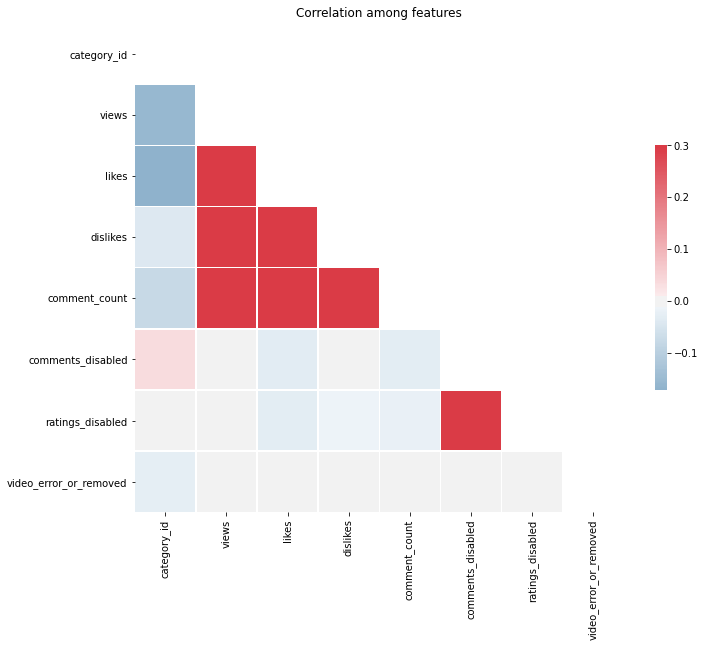

In [24]:
#Calculate the correlation amond different features
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=fig_size)
plt.title('Correlation among features')
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the above visualization it can be seen that there is positive correlation between view, likes, dislikes, views and comment_count


## Histogram of variables

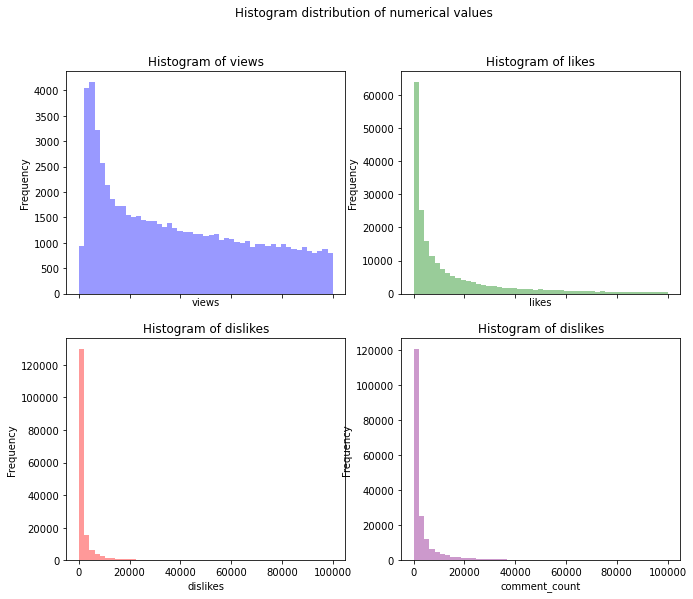

In [69]:
def visualize_histogram(data):
    """
     Description:A function to visulize histograms usin
    :param data: pandas dataframe
    :param col: the column name whose histogram needs to be visualized
    :return: dataframe
    """
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(fig_size))
    fig.suptitle('Histogram distribution of numerical values')
    
    sns.distplot(df['views'], bins=np.linspace(1e2, 1e5, 50), kde=False, color='blue', ax=axes[0][0])
    axes[0][0].set_title('Histogram of views')
    axes[0][0].set_xlabel('views')
    axes[0][0].set_ylabel('Frequency')
    
    sns.distplot(df['likes'], bins=np.linspace(1e2, 1e5, 50), kde=False, color='green', ax=axes[0][1])
    axes[0][1].set_title('Histogram of likes')
    axes[0][1].set_xlabel('likes')
    axes[0][1].set_ylabel('Frequency')
    
    sns.distplot(df['dislikes'], bins=np.linspace(1e2, 1e5, 50), kde=False, color='red', ax=axes[1][0])
    axes[1][0].set_title('Histogram of dislikes')
    axes[1][0].set_xlabel('dislikes')
    axes[1][0].set_ylabel('Frequency')
    
    sns.distplot(df['comment_count'], bins=np.linspace(1e2, 1e5, 50), kde=False, color='purple', ax=axes[1][1])
    axes[1][1].set_title('Histogram of dislikes')
    axes[1][1].set_xlabel('comment_count')
    axes[1][1].set_ylabel('Frequency')

visualize_histogram(df)

## Barplot of category count

Text(0.5, 1.0, 'Distribution of Categories')

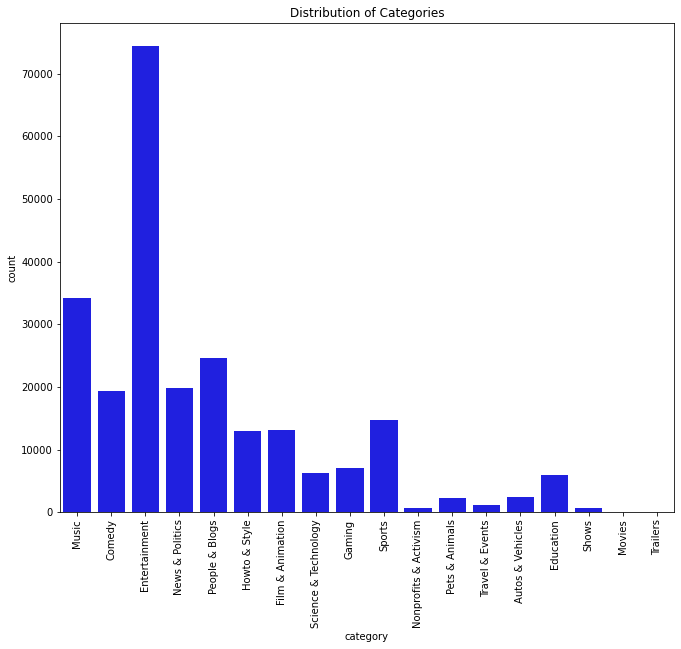

In [88]:
data = json.loads(open('./data/US_category_id.json').read())
cateogry_id_title_dict = dict()
for item in data['items']:
    cateogry_id_title_dict[int(item['id'])] = item['snippet']['title'] 
df['category'] = df.apply (lambda row: cateogry_id_title_dict[int(row['category_id'])], axis=1)

fig, ax = plt.subplots(figsize=fig_size)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.countplot(x='category', data=df, color="blue")
plt.title('Distribution of Categories')

## Number of videos in each region

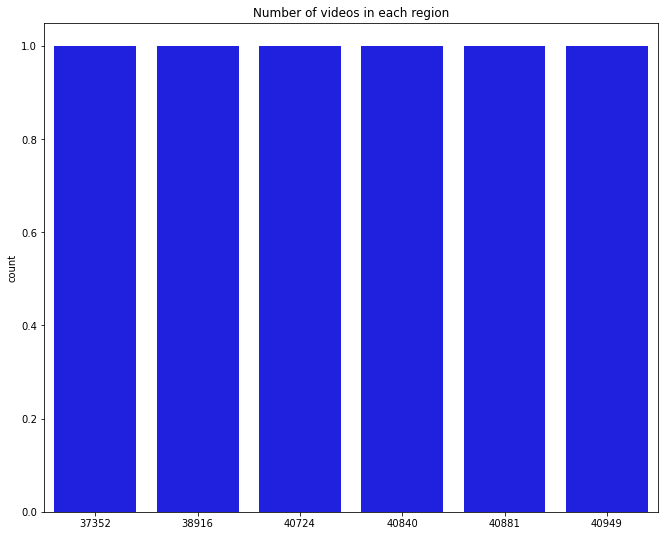

In [35]:
fig, ax = plt.subplots(figsize=fig_size)
plt.title('Number of videos in each region')
sns.countplot(x=[data[key].shape[0] for key in data], color="blue")

## Number of hours it takes for a video to go trending

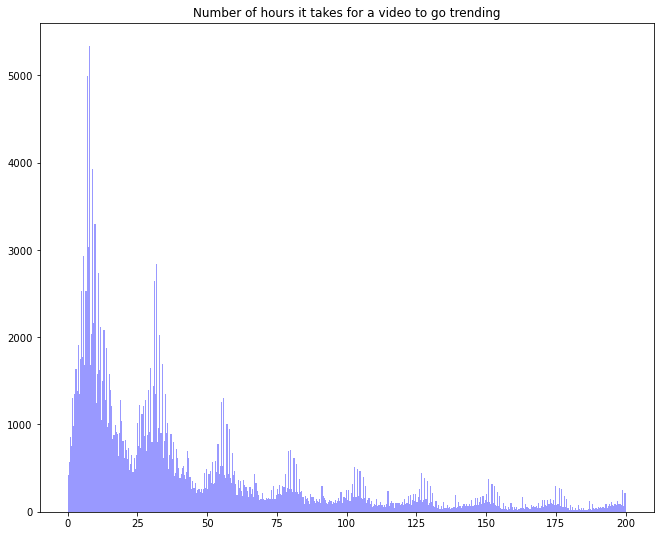

In [66]:
trending_time = pd.to_datetime(df[date_cols[1]], format="%y.%d.%m") 
publish_time = pd.to_datetime(df['publish_time'], infer_datetime_format=True).dt.tz_localize(None)  
number_of_hours = (trending_time - publish_time) / np.timedelta64(1, 'h')
fig, ax = plt.subplots(figsize=fig_size)
plt.title('Number of hours it takes for a video to go trending')
sns.distplot(number_of_hours, bins=np.linspace(0, 200, 500), kde=False, color='blue', ax=ax)

In [67]:
np.linspace(1e2, 1e5, 50)

array([   100.        ,   2138.7755102 ,   4177.55102041,   6216.32653061,
         8255.10204082,  10293.87755102,  12332.65306122,  14371.42857143,
        16410.20408163,  18448.97959184,  20487.75510204,  22526.53061224,
        24565.30612245,  26604.08163265,  28642.85714286,  30681.63265306,
        32720.40816327,  34759.18367347,  36797.95918367,  38836.73469388,
        40875.51020408,  42914.28571429,  44953.06122449,  46991.83673469,
        49030.6122449 ,  51069.3877551 ,  53108.16326531,  55146.93877551,
        57185.71428571,  59224.48979592,  61263.26530612,  63302.04081633,
        65340.81632653,  67379.59183673,  69418.36734694,  71457.14285714,
        73495.91836735,  75534.69387755,  77573.46938776,  79612.24489796,
        81651.02040816,  83689.79591837,  85728.57142857,  87767.34693878,
        89806.12244898,  91844.89795918,  93883.67346939,  95922.44897959,
        97961.2244898 , 100000.        ])

In [81]:
cateogry_id_title_dict

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}